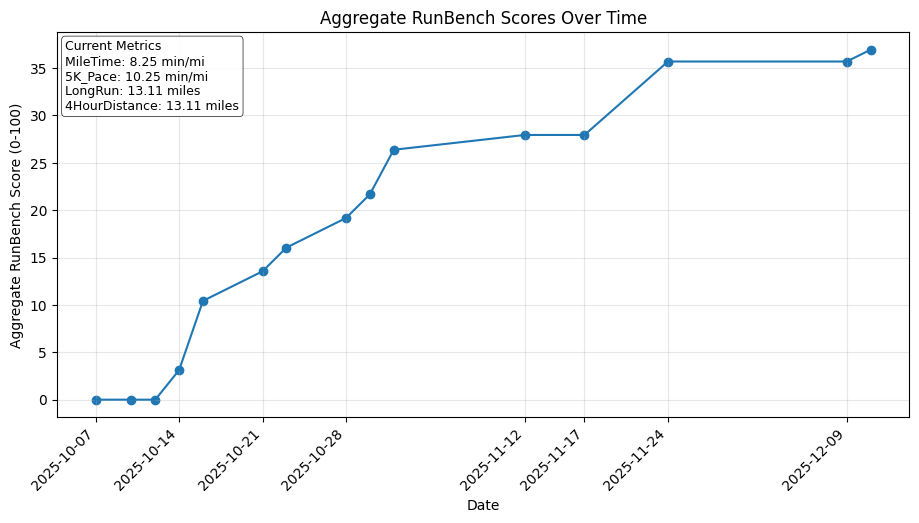

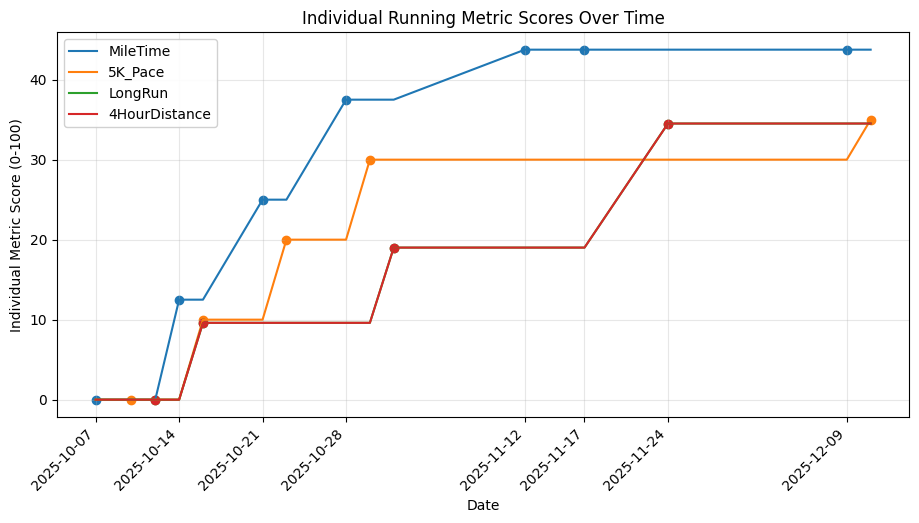

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
})

# Goals for each metric
GOALS = {
    "MileTime": 6.0,         # Goal: 6 min/mile (lower is better)
    "5K_Pace": 7.0,          # Goal: 7 min/mile for 5K (lower is better)
    "LongRun": 26.2,         # Goal: Marathon distance in miles (higher is better)
    "4HourDistance": 26.2,   # Goal: Marathon distance in 4 hours (higher is better)
}

# Base values for each metric
BASE = {
    "MileTime": 10.0,        # Base: 10 min/mile
    "5K_Pace": 12.0,         # Base: 12 min/mile for 5K
    "LongRun": 6.21,         # Base: 10K distance in miles
    "4HourDistance": 6.21,   # Base: 10K distance in 4 hours
}

# Function to calculate score (handles both "higher is better" and "lower is better")
def score(series: pd.Series, metric: str) -> pd.Series:
    """Compute a score for each value in the series based on the metric."""
    goal = GOALS[metric]
    base = BASE[metric]

    # For time-based metrics (lower is better), invert the calculation
    if metric in ["MileTime", "5K_Pace"]:
        return ((base - series) / (base - goal) * 100).clip(0, 100)
    # For distance-based metrics (higher is better)
    return ((series - base) / (goal - base) * 100).clip(0, 100)

# User inputted data here
data = [
    # Week 1
    ("2025-10-07", {
        "MileTime": 10.0,
    }),
    ("2025-10-10", {
        "5K_Pace": 12.0,
    }),
    ("2025-10-12", {
        "LongRun": 6.21,          # 10 km
        "4HourDistance": 6.21,    # 10 km
    }),

    # Week 2
    ("2025-10-14", {
        "MileTime": 9.5,          # 9 min 30 sec
    }),
    ("2025-10-16", {
        "5K_Pace": 11.5,          # 11 min 30 sec
        "LongRun": 8.13,          # 13.08 km
        "4HourDistance": 8.13,    # 13.08 km
    }),

    # Week 3
    ("2025-10-21", {
        "MileTime": 9.0,
    }),
    ("2025-10-23", {
        "5K_Pace": 11.0,
    }),

    # Week 4
    ("2025-10-28", {
        "MileTime": 8.5,          # 8 min 30 sec
    }),
    ("2025-10-30", {
        "5K_Pace": 10.5,          # 10 min 30 sec
    }),
    ("2025-11-01", {
        "LongRun": 10.01,          # 16.11 km
        "4HourDistance": 10.01,    # 16.11 km
    }),

    # Week 6
    ("2025-11-12", {
        "MileTime": 8.25,          # 8 min 15 sec, only did 75% of HIIT
    }),

    # Week 7
    ("2025-11-17", {
        "MileTime": 8.25,          # 8 min 15 sec, only did 75% of HIIT
    }),

    # Week 9
    ("2025-11-24", {
        "LongRun": 13.11,          # 21.10 km
        "4HourDistance": 13.11,    # 21.10 km
    }),

    # Week 11
    ("2025-12-09", {
        "MileTime": 8.25,          # 8 min 15 sec
    }),
    ("2025-12-11", {
        "5K_Pace": 10.25,          # 10 min 15 sec
    }),
]

# Turn data into a pandas DataFrame
rows = []
for date, values in data:
    row = {"Date": pd.to_datetime(date)}
    row.update(values)
    rows.append(row)
df = pd.DataFrame(rows).set_index("Date").sort_index()

# Days where any metric was recorded
performed = df.notna()

# Fill in missing values with the previous value, and fill in missing values with BASE
df_filled = df.ffill()
for metric in GOALS:
    if metric in df_filled.columns:
        df_filled[metric] = df_filled[metric].fillna(BASE[metric])

# Calculate scores for each metric and the overall RunBench
scores = pd.DataFrame(
    {
        metric: score(df_filled[metric], metric)
        for metric in GOALS
        if metric in df_filled.columns
    },
    index=df_filled.index,
)
metric_cols = [m for m in GOALS if m in df_filled.columns]
scores["RunBench"] = scores[metric_cols].mean(axis=1)

# Create the figure and plot the RunBench
fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(scores.index, scores["RunBench"])

# Mark the session days
session_days = performed.any(axis=1)
ax.scatter(
    scores.index[session_days],
    scores["RunBench"][session_days],
)

# Add a title, labels, and a grid
plt.title("Aggregate RunBench Scores Over Time")
plt.xlabel("Date")
plt.ylabel("Aggregate RunBench Score (0-100)")
plt.grid(visible=True, alpha=0.3)

# Group by weeks that START Monday (i.e., weeks END Sunday => "W-SUN")
first_session_each_week = (
    scores.index.to_series()
    .groupby(scores.index.to_period("W-SUN"))
    .min()
    .sort_values()
)

# Use only those dates as x-ticks, rotate 45°
ax.set_xticks(first_session_each_week.tolist())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Get the latest metric values
latest_w = df_filled.iloc[-1][metric_cols]

# Add the latest metric values to the plot
labels = []
for metric in GOALS:
    if metric in latest_w.index:
        if metric in ["MileTime", "5K_Pace"]:
            labels.append(f"{metric}: {latest_w[metric]:.2f} min/mi")
        else:
            labels.append(f"{metric}: {latest_w[metric]:.2f} miles")

text = "\n".join(labels)
ax.text(
    0.01,
    0.98,
    "Current Metrics\n" + text,
    transform=ax.transAxes,
    va="top",
    ha="left",
    bbox={"boxstyle": "round", "facecolor": "white", "alpha": 0.9, "linewidth": 0.5},
    fontsize=9,
)

# Save the figure
plt.savefig("plots/aggregate_runbench.png", dpi=1000, bbox_inches="tight")

# Create the figure for individual metrics
fig, ax = plt.subplots(figsize=(11, 5))

# Plot each metric
for metric in metric_cols:
    ax.plot(
        scores.index,
        scores[metric],
        label=metric,
    )
    idx = df.index[performed[metric]]
    ax.scatter(
        idx,
        scores.loc[idx, metric],
    )

# Add a title, labels, a grid, and a legend
ax.set_title("Individual Running Metric Scores Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Individual Metric Score (0-100)")
ax.grid(visible=True, alpha=0.3)
ax.legend(loc="upper left", frameon=True, framealpha=0.9)

# Group by weeks that START Monday (i.e., weeks END Sunday => "W-SUN")
first_session_each_week = (
    scores.index.to_series()
    .groupby(scores.index.to_period("W-SUN"))
    .min()
    .sort_values()
)

# Use only those dates as x-ticks, rotate 45°
ax.set_xticks(first_session_each_week.tolist())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Save the figure
plt.savefig("plots/individual_runbench.png", dpi=1000, bbox_inches="tight")